# Import libs

In [12]:
# sklearn libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso

# implemented structure
from src.handleData import handleData
from src.handleClassifier import handleClassifier
from src.handleResult import handleResult

# Load data

In [13]:
hD = handleData("./data/data.csv")  # construct handleData object
df = hD.loadData("id")  # load the data
labels = hD.encodeLabels(df, "species")  # get labels
dfTrain, dfTest = hD.splitData(df, 0.7, "species")  # get the training and testing sets

# Without any feature trimming

In [14]:
# The selected classifiers and their config
classifierList = [
    {
        "name": "LinearDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "QuadraticDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "AdaBoostClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__learning_rate": [0.01, 0.1, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "BaggingClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__max_samples": [0.25, 0.5, 0.75, 1.0],
                    "clf__max_features": [0.25, 0.5, 0.75, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
]

hC = handleClassifier()  # construct handleClassifier object
clf = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.8773224898342196
BaggingClassifier, GridSearchCV best score = 0.8471275153790012
LinearDiscriminantAnalysis, CV score = 0.9451986237097278
QuadraticDiscriminantAnalysis, CV score = 0.02743196746950266


# With feature reduction (PCA)

In [15]:
# change the config for a feature reduction
for classifierDict in classifierList:
    classifierDict["preprocess"] = True
    classifierDict["feature"] = {"option": "reduction"}
    classifierDict["fitStrategy"]["option"] = "GridSearch"

    if not "param_grid" in classifierDict["fitStrategy"]["config"]:
        classifierDict["fitStrategy"]["config"]["param_grid"] = dict()

    classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"] = [
        0.5,
        0.75,
        0.85,
    ]

clfReduction = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.904806589511
BaggingClassifier, GridSearchCV best score = 0.923532478365134
LinearDiscriminantAnalysis, GridSearchCV best score = 0.9552914190386821
QuadraticDiscriminantAnalysis, GridSearchCV best score = 0.15465540610989473


# With feature selection (Lasso)

In [16]:
# change the config for a feature selection
for classifierDict in classifierList:
    classifierDict["feature"]["option"] = "selection"
    classifierDict["feature"]["config"] = {"estimator": Lasso()}
    del classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"]
    classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__estimator__alpha"] = [
        1.0,
        2.5,
        5.0,
    ]

clfSelection = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.8528203524137213
BaggingClassifier, GridSearchCV best score = 0.8816494630382652
LinearDiscriminantAnalysis, GridSearchCV best score = 0.8917735376915858
QuadraticDiscriminantAnalysis, GridSearchCV best score = 0.03608591387759358


# Prediction results
## Any feature trimming

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.912458,0.934343,0.912458,0.910847,0.999004
BaggingClassifier,0.912458,0.903367,0.912458,0.900697,0.999187
LinearDiscriminantAnalysis,0.976431,0.983333,0.976431,0.976118,0.999966
QuadraticDiscriminantAnalysis,0.033670,0.046577,0.033670,0.034680,0.511905


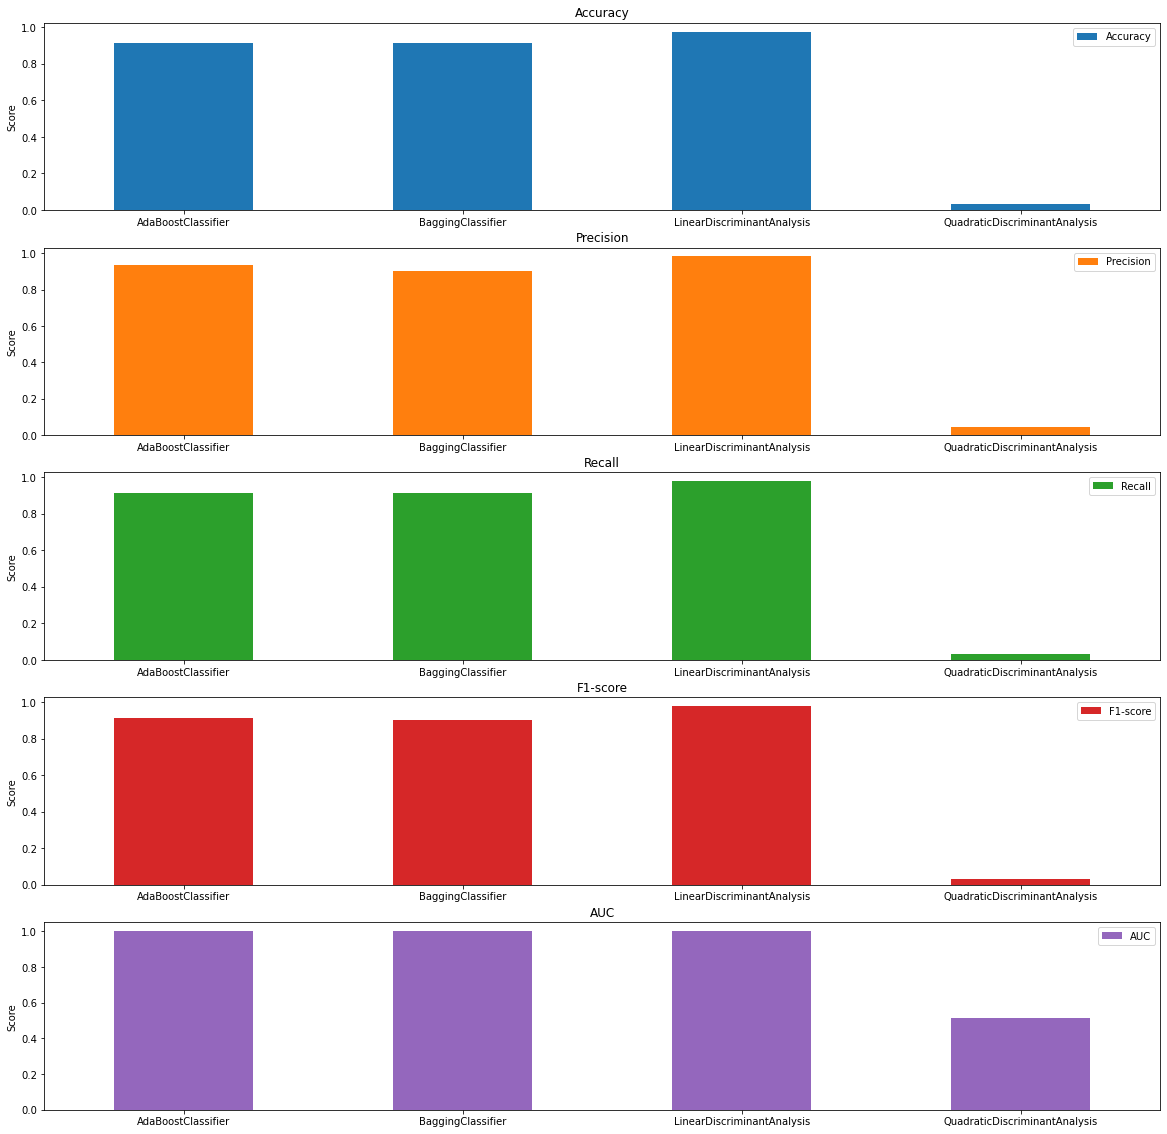

In [17]:
hR = handleResult()
hR.predictionResult(dfTest, clf)
hR.plotBarChart()

## Feature reduction

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.949495,0.960606,0.949495,0.947835,0.999771
BaggingClassifier,0.949495,0.960606,0.949495,0.946681,0.999611
LinearDiscriminantAnalysis,0.962963,0.975758,0.962963,0.961207,0.999943
QuadraticDiscriminantAnalysis,0.653199,0.683742,0.653199,0.636989,0.981396


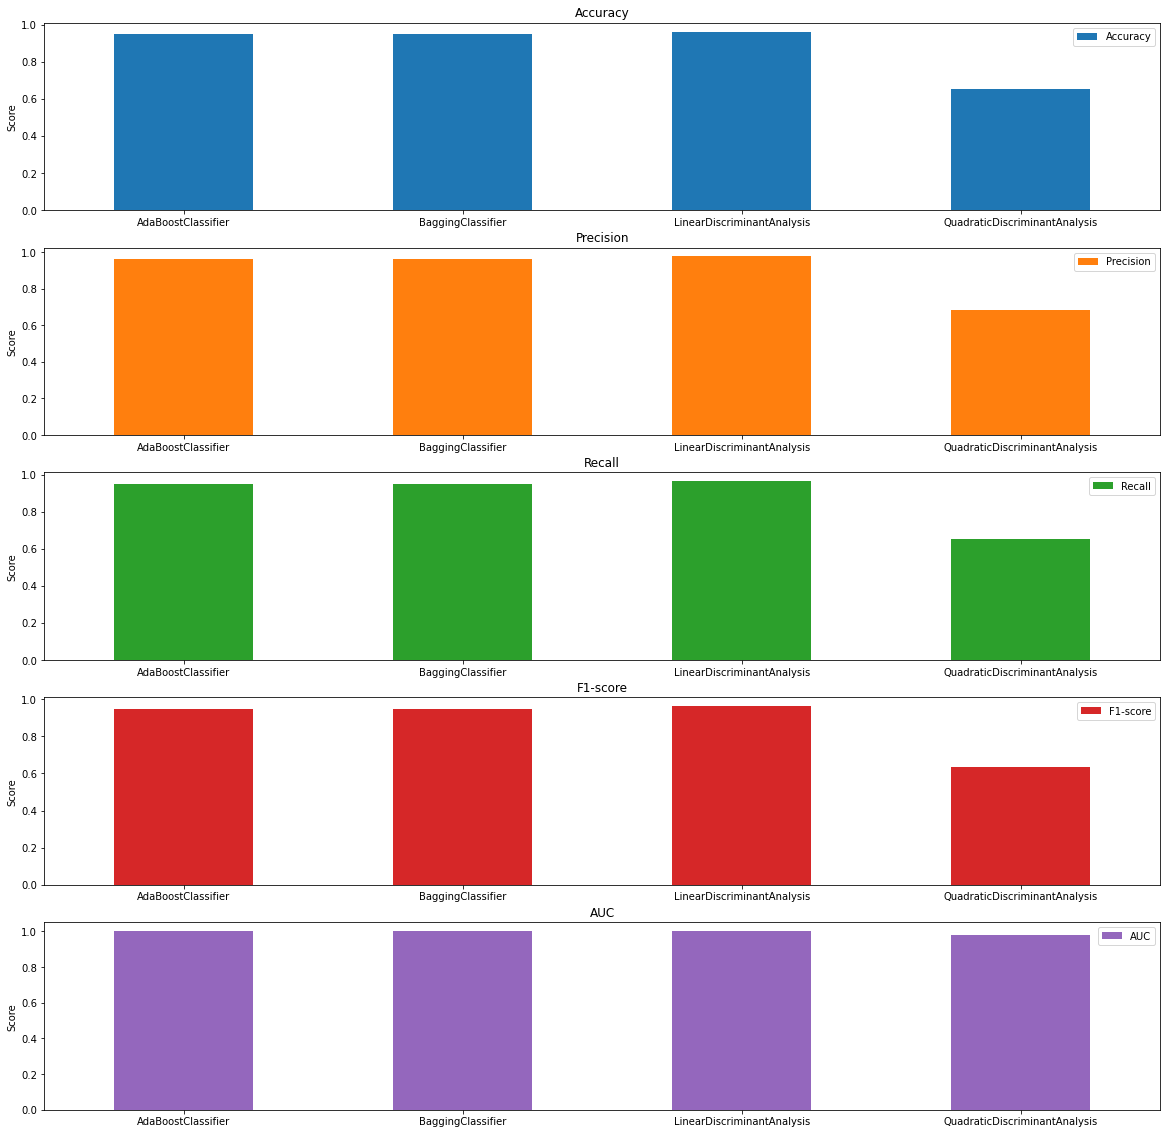

In [18]:
hR.predictionResult(dfTest, clfReduction)
hR.plotBarChart()

## Feature selection

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.892256,0.912458,0.892256,0.890452,0.996622
BaggingClassifier,0.922559,0.933165,0.922559,0.918110,0.998935
LinearDiscriminantAnalysis,0.946128,0.960606,0.946128,0.943314,0.996908
QuadraticDiscriminantAnalysis,0.016835,0.016330,0.016835,0.016186,0.503401


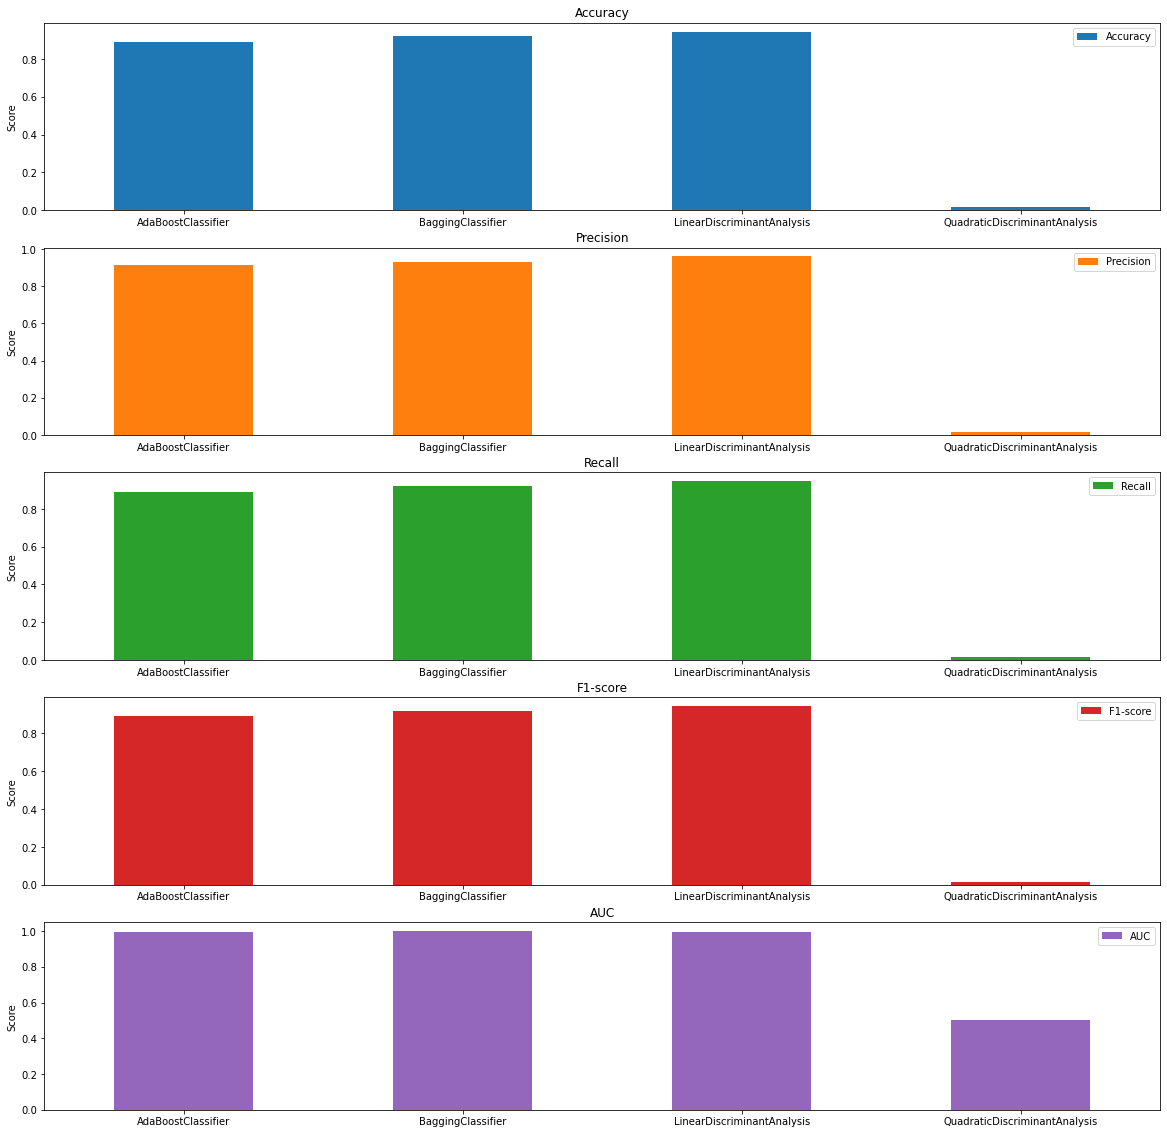

In [19]:
hR.predictionResult(dfTest, clfSelection)
hR.plotBarChart()